# Data analysis: Covid cases over time

Data analysis of daily new covid cases in different countries, using data from:

https://github.com/CSSEGISandData/COVID-19

## Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime, timedelta

In [2]:
plt.style.use("ggplot")

## Import and clean up data

In [3]:
def read_csv(file, response):
    return (
        pd.read_csv(file)
        # Remove unused columns
        .drop(["Lat", "Long"], axis=1)
        # Make the date a column
        .melt(id_vars=["Province/State", "Country/Region"], var_name="Date", value_name=response)
        # Convert the date from string to a real date
        .assign(**{"Date": lambda df: pd.to_datetime(df["Date"])})
        # Aggregate provinces
        .groupby(["Country/Region", "Date"])
        .sum()
        # Convert cumulative totals to daily increments
        .groupby(level="Country/Region")
        .diff()
    )

In [4]:
cases_df = read_csv("time_series_covid19_confirmed_global.csv", "Cases")

In [5]:
cases_df.head(5)

Cases
Country/Region Date             
Afghanistan    2020-01-22    NaN
               2020-01-23    0.0
               2020-01-24    0.0
               2020-01-25    0.0
               2020-01-26    0.0

In [6]:
deaths_df = read_csv("time_series_covid19_deaths_global.csv", "Deaths")

In [7]:
deaths_df.head(5)

Deaths
Country/Region Date              
Afghanistan    2020-01-22     NaN
               2020-01-23     0.0
               2020-01-24     0.0
               2020-01-25     0.0
               2020-01-26     0.0

In [8]:
df = cases_df.join(deaths_df)

In [9]:
df.head(5)

Cases  Deaths
Country/Region Date                     
Afghanistan    2020-01-22    NaN     NaN
               2020-01-23    0.0     0.0
               2020-01-24    0.0     0.0
               2020-01-25    0.0     0.0
               2020-01-26    0.0     0.0

## Analyze

In [10]:
date_from = pd.to_datetime("2021-01-01")
date_to   = pd.to_datetime("2021-12-31")

countries = sorted([
    "Poland",
    "Czechia",
    "Germany",
    "Austria",
    "United Kingdom"
])

In [11]:
def plot(df):
    fig, ax = plt.subplots(figsize=(16,5))
    for col in df.columns:
        ax.plot(df.index, df[col], label=col)
    ax.legend(loc="center left", bbox_to_anchor=(1.02, 0.5))

### Plot cases day by day

In [12]:
cases_day_by_day = df.loc[(countries, slice(date_from, date_to)), "Cases"]
cases_day_by_day.groupby(level="Country/Region").head()

Country/Region  Date      
Austria         2021-01-01     2096.0
                2021-01-02     1391.0
                2021-01-03     1466.0
                2021-01-04     1642.0
                2021-01-05     2311.0
Czechia         2021-01-01    13361.0
                2021-01-02     3447.0
                2021-01-03     5012.0
                2021-01-04     6233.0
                2021-01-05    12921.0
Germany         2021-01-01    15575.0
                2021-01-02    11036.0
                2021-01-03    10356.0
                2021-01-04    12320.0
                2021-01-05    18349.0
Poland          2021-01-01    10896.0
                2021-01-02     7006.0
                2021-01-03     5782.0
                2021-01-04     4385.0
                2021-01-05     7596.0
United Kingdom  2021-01-01    53458.0
                2021-01-02    57853.0
                2021-01-03    55157.0
                2021-01-04    58923.0
                2021-01-05    61087.0
Name: Cases, dtype: flo

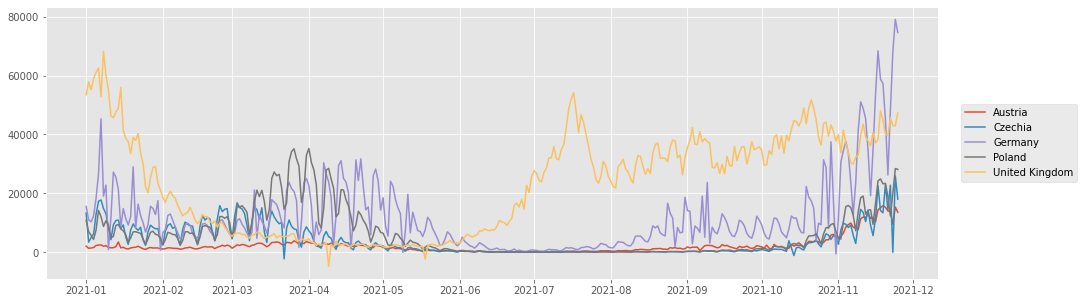

In [13]:
plot(cases_day_by_day.unstack(level="Country/Region"))

### Plot cases week-by-week

In [14]:
def week_start(dt):
    return dt - timedelta(days=dt.weekday())

In [15]:
cases_week_by_week = (
    cases_df.loc[(countries, slice(week_start(date_from), date_to)), "Cases"]
    .groupby(level="Country/Region")
    .resample("1W", level="Date")
    .sum()
)
cases_week_by_week.groupby(level="Country/Region").head()

Country/Region  Date      
Austria         2021-01-03     13876.0
                2021-01-10     14954.0
                2021-01-17     13056.0
                2021-01-24     10936.0
                2021-01-31      9684.0
Czechia         2021-01-03     69882.0
                2021-01-10     90684.0
                2021-01-17     57994.0
                2021-01-24     48458.0
                2021-01-31     47157.0
Germany         2021-01-03    125257.0
                2021-01-10    145514.0
                2021-01-17    120719.0
                2021-01-24     97640.0
                2021-01-31     77890.0
Poland          2021-01-03     60763.0
                2021-01-10     66960.0
                2021-01-17     50060.0
                2021-01-24     39863.0
                2021-01-31     37940.0
United Kingdom  2021-01-03    367471.0
                2021-01-10    418669.0
                2021-01-17    324372.0
                2021-01-24    252117.0
                2021-01-31    170326.

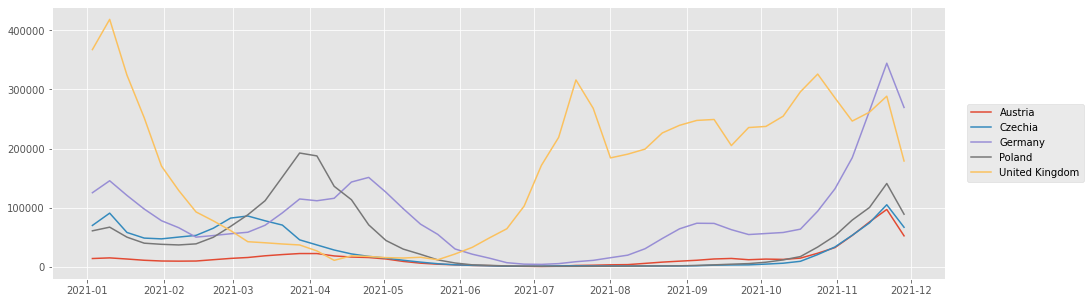

In [16]:
plot(cases_week_by_week.unstack(level="Country/Region"))

### Plot moving average of cases

In [17]:
def moving_average(df, date_from, date_to):
    window_days = 7
    return (
        df.loc[(slice(None), slice(date_from - timedelta(days=window_days-1), date_to)), :]
        .groupby(level="Country/Region")
        .apply(lambda s: s.rolling(7).sum())
        .loc[(countries, slice(date_from, date_to)), :]
    )

In [18]:
cases_moving_average = moving_average(df.loc[countries], date_from, date_to)
cases_moving_average.groupby(level="Country/Region").tail(10)

Cases  Deaths
Country/Region Date                        
Austria        2021-11-16   82127.0   253.0
               2021-11-17   85145.0   271.0
               2021-11-18   88315.0   302.0
               2021-11-19   92326.0   310.0
               2021-11-20   94471.0   304.0
               2021-11-21   96961.0   309.0
               2021-11-22   98878.0   296.0
               2021-11-23   98028.0   307.0
               2021-11-24   98977.0   332.0
               2021-11-25   97424.0   330.0
Czechia        2021-11-16   79189.0   463.0
               2021-11-17   87195.0   480.0
               2021-11-18   87845.0   480.0
               2021-11-19   90847.0   524.0
               2021-11-20   99643.0   574.0
               2021-11-21  104886.0   598.0
               2021-11-22  121994.0   763.0
               2021-11-23  110440.0   668.0
               2021-11-24  113804.0   699.0
               2021-11-25  117664.0   754.0
Germany        2021-11-16  287364.0  1310.0
               2021-11-17  304653.0  1341.0
               2021-11-18  314587.0  1357.0
               2021-11-19  326533.0  1370.0
               2021-11-20  337407.0  1390.0
               2021-11-21  344445.0  1410.0
               2021-11-22  357374.0  1451.0
               2021-11-23  371796.0  1495.0
               2021-11-24  382481.0  1579.0
               2021-11-25  398292.0  1729.0
Poland         2021-11-16  105455.0  1181.0
               2021-11-17  111150.0  1374.0
               2021-11-18  116983.0  1470.0
               2021-11-19  127277.0  1844.0
               2021-11-20  136397.0  1960.0
               2021-11-21  140873.0  1955.0
               2021-11-22  143740.0  1951.0
               2021-11-23  147064.0  2067.0
               2021-11-24  151254.0  2064.0
               2021-11-25  154485.0  2192.0
United Kingdom 2021-11-16  274178.0  1042.0
               2021-11-17  272733.0  1027.0
               2021-11-18  277275.0  1028.0
               2021-11-19  282961.0  1042.0
               2021-11-20  285307.0  1034.0
               2021-11-21  288638.0  1032.0
               2021-11-22  293626.0  1030.0
               2021-11-23  299516.0   981.0
               2021-11-24  304212.0   929.0
               2021-11-25  303446.0   877.0

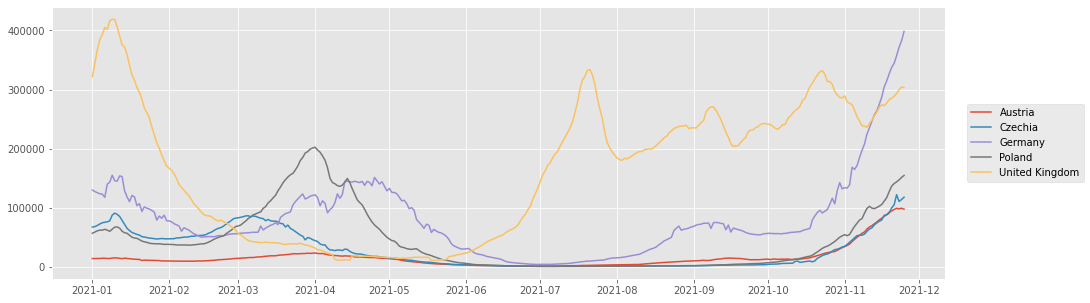

In [19]:
plot(cases_moving_average.loc[:, "Cases"].unstack(level="Country/Region"))

### Compare 2020 and 2021

In [20]:
def moving_average_year_to_year(df, date_from, date_to):
    levels = [countries, pd.date_range(date_from, date_to)]
    index = pd.MultiIndex.from_product(levels, names=df.index.names)

    return (
        moving_average(df.loc[countries], date_from, date_to)
        .reindex(index)
        .reset_index()
        .assign(**{
            "Year": lambda df: df["Date"].dt.year,
            "Day": lambda df: df["Date"].dt.strftime("%m-%d")
        })
        .drop(columns=["Date"])
        .set_index(["Country/Region", "Year", "Day"])
        .sort_index()
    )

In [21]:
cases_year_to_year = moving_average_year_to_year(df.loc[countries], pd.to_datetime("2020-01-01"), pd.to_datetime("2021-12-31"))
cases_year_to_year.head(5)

Cases  Deaths
Country/Region Year Day                 
Austria        2020 01-01    NaN     NaN
                    01-02    NaN     NaN
                    01-03    NaN     NaN
                    01-04    NaN     NaN
                    01-05    NaN     NaN

In [22]:
def plot_cases_year_to_year(df):
    countries, years, days = df.index.levels
    
    fig, axs = plt.subplots(nrows=len(countries), ncols=2, figsize=(16, 24))
    plt.subplots_adjust(hspace=0.45)
    
    for axs_row, country in zip(axs, countries):
        for ax, response in zip(axs_row, ["Cases", "Deaths"]):
            for year in years:
                cases = df.loc[(country, year)]
                ax.plot(cases.index, cases[response], label=year)

            ax.set_title(f"{country} - {response}")
            ax.set_xticks([day for day in days if day.endswith("-01")])
            ax.legend(loc="center", ncol=2, bbox_to_anchor=(0.5, -0.2))

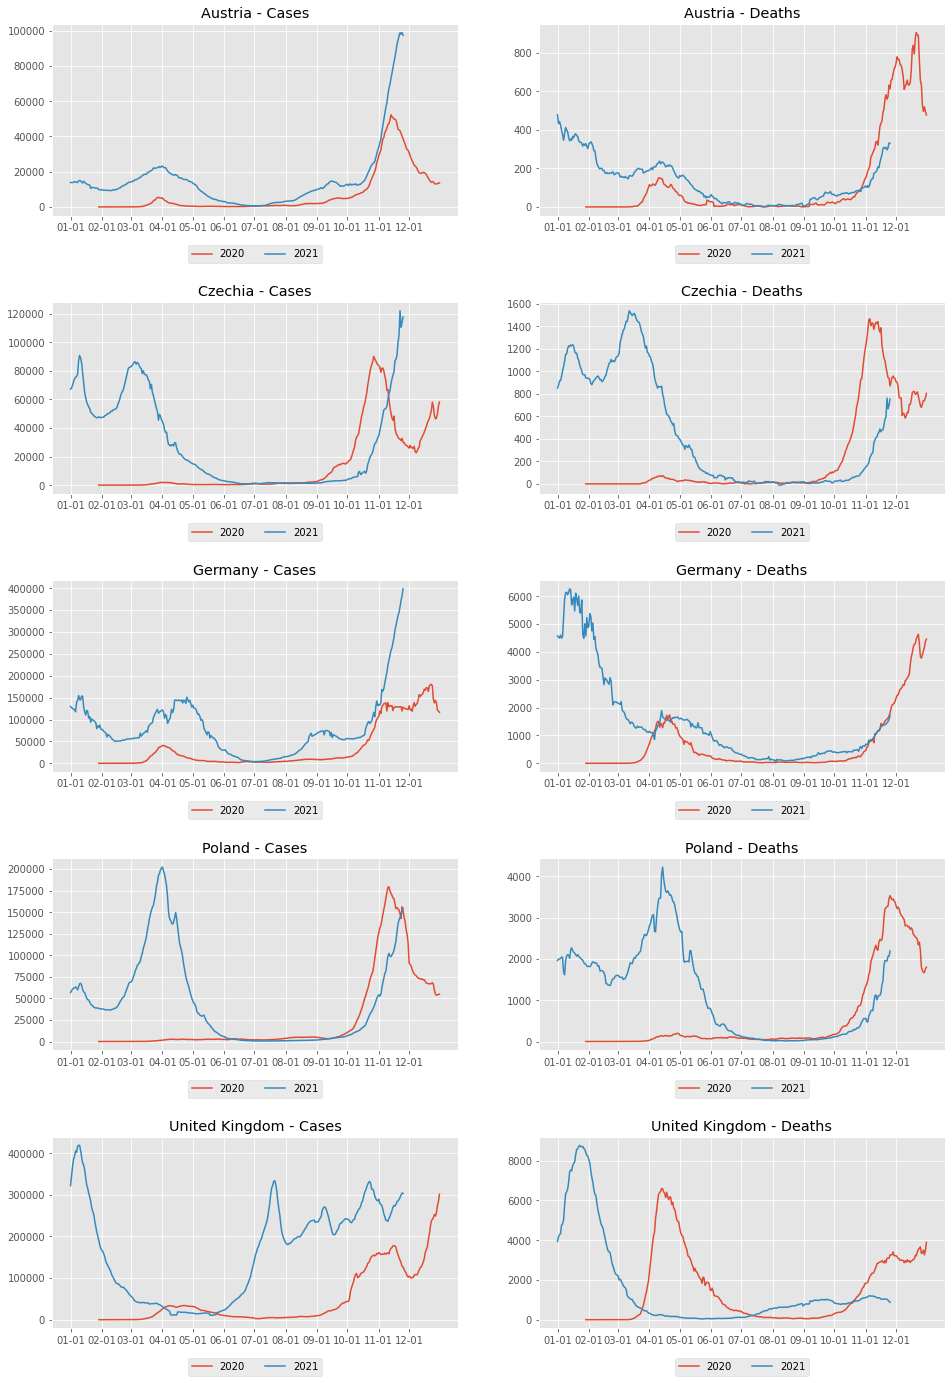

In [23]:
plot_cases_year_to_year(cases_year_to_year)